In [1]:
!pip install qiskit qiskit-aer

In [2]:
!pip install pylatexenc --quiet

In [3]:
!pip install qiskit qiskit-aer matplotlib --quiet

In [31]:
# Imports
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline

In [32]:
# Define Inverse Quantum Fourier Transform (QFT)

def inverse_qft(qc, n):
    """Apply the inverse Quantum Fourier Transform on n qubits."""
    for qubit in range(n // 2):
        qc.swap(qubit, n - qubit - 1)
    for j in range(n):
        qc.h(j)
        for k in range(j):
            qc.cp(-np.pi / 2 ** (j - k), k, j)
    return qc

In [33]:
# Create Quantum Phase Estimation Circuit
def qpe_circuit(num_count_qubits, theta, visualize=False):
    """
    Construct QPE circuit for given theta value.
    visualize=True draws the inverse QFT structure (Task 4).
    """
    qc = QuantumCircuit(num_count_qubits + 1, num_count_qubits)

    # Step 1: Hadamard on counting qubits
    qc.h(range(num_count_qubits))

    # Step 2: Prepare eigenstate |1>
    qc.x(num_count_qubits)

    # Step 3: Controlled-U operations (phase rotations)
    for qubit in range(num_count_qubits):
        qc.cp(2 * np.pi * theta * (2 ** qubit), qubit, num_count_qubits)

    # Step 4: Apply inverse QFT
    inverse_qft(qc, num_count_qubits)

    # Step 4.1: Visualize inverse QFT (Task 4)
    if visualize:
        try:
            display(qc.draw("mpl"))
        except Exception:
            print("Could not render mpl circuit (pylatexenc missing). Showing text diagram:")
            print(qc.draw(output="text"))

    # Step 5: Correct measurement mapping (important!)
    qc.measure(range(num_count_qubits), reversed(range(num_count_qubits)))

    return qc


In [34]:
# Compare Measured Result with Theoretical Phase

def compare_with_theory(counts, theta, num_count_qubits):
    """Compare measured result with theoretical phase binary."""
    expected_decimal = round(theta * 2 ** num_count_qubits)
    expected_binary = format(expected_decimal, f"0{num_count_qubits}b")
    measured_binary = max(counts, key=counts.get)

    print("\n=== Comparison with Theory ===")
    print(f"Theoretical θ = {theta}")
    print(f"Expected decimal = {expected_decimal}")
    print(f"Expected binary ({num_count_qubits} bits) = {expected_binary}")
    print(f"Measured most frequent output = {measured_binary}")

    if measured_binary == expected_binary:
        print("Match — Simulation agrees with theory.")
    else:
        print("Does NOT match — due to rounding, noise, or limited qubits.")


In [37]:
def run_qpe(num_count_qubits=3, theta=0.125, noisy=False, visualize=False):
    """Runs QPE and shows histogram + circuit + theoretical comparison."""
    simulator = AerSimulator()

    if noisy:
        noise_model = NoiseModel()
        noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01, 1), ["h", "x"])
        noise_model.add_all_qubit_quantum_error(depolarizing_error(0.02, 2), ["cp"])
    else:
        noise_model = None

    qc = qpe_circuit(num_count_qubits, theta, visualize)
    compiled = transpile(qc, simulator)
    result = simulator.run(compiled, shots=2048, noise_model=noise_model).result()
    counts = result.get_counts()

    # Check counts before plotting
    if not counts:
        print("No counts found. Possibly due to measurement mismatch.")
        print(qc.draw(output='text'))
        return
    else:
        print("Counts collected successfully:", counts)

    try:
        fig = plt.figure(figsize=(6, 4))
        ax = fig.add_subplot(111)
        items = sorted(counts.items(), key=lambda x: x[0])
        bars = [x[0] for x in items]
        heights = [x[1] for x in items]
        ax.bar(bars, heights, color='steelblue', edgecolor='black')
        ax.set_title(f"QPE Result (θ={theta}, Qubits={num_count_qubits}, Noisy={noisy})")
        ax.set_xlabel("Measured Output (Binary)")
        ax.set_ylabel("Counts")
        for i, v in enumerate(heights):
          ax.text(i, v + 10, str(v), ha='center', fontsize=9)
          ax.grid(True, linestyle='--', alpha=0.4)
          plt.show()

    except Exception as e:
        print("plot_histogram failed — rendering manually using matplotlib.")
        plt.figure(figsize=(6, 4))
        items = sorted(counts.items(), key=lambda x: x[0])
        bars = [x[0] for x in items]
        heights = [x[1] for x in items]
        plt.bar(bars, heights, color='skyblue', edgecolor='black')
        plt.title(f"QPE Result (θ={theta}, Qubits={num_count_qubits}, Noisy={noisy})")
        plt.xlabel("Measured Output (Binary)")
        plt.ylabel("Counts")
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.show()

    # Print text circuit
    print(qc.draw(output="text"))

    # Compare with theoretical
    compare_with_theory(counts, theta, num_count_qubits)

    return counts



=== TASK 1: Change Phase Value ===
Counts collected successfully: {'010': 1048, '011': 1000}


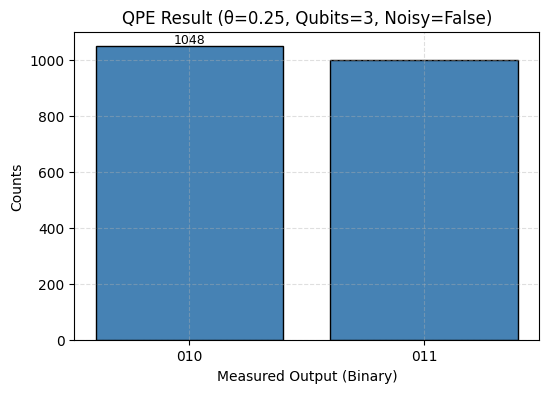

     ┌───┐                           ┌───┐                              ┌─┐   »
q_0: ┤ H ├─■───────────────────────X─┤ H ├─■─────────■──────────────────┤M├───»
     ├───┤ │               ┌───┐   │ └───┘ │P(-π/2)  │                  └╥┘┌─┐»
q_1: ┤ H ├─┼────────■──────┤ H ├───┼───────■─────────┼─────────■─────────╫─┤M├»
     ├───┤ │        │      └───┘   │ ┌───┐           │P(-π/4)  │P(-π/2)  ║ └╥┘»
q_2: ┤ H ├─┼────────┼──────■───────X─┤ H ├───────────■─────────■─────────╫──╫─»
     ├───┤ │P(π/2)  │P(π)  │P(2π)    └───┘                               ║  ║ »
q_3: ┤ X ├─■────────■──────■─────────────────────────────────────────────╫──╫─»
     └───┘                                                               ║  ║ »
c: 3/════════════════════════════════════════════════════════════════════╩══╩═»
                                                                         2  1 »
«        
«q_0: ───
«        
«q_1: ───
«     ┌─┐
«q_2: ┤M├
«     └╥┘
«q_3: ─╫─
«      ║ 
«c: 3/═╩═
«      0 

=== Compa

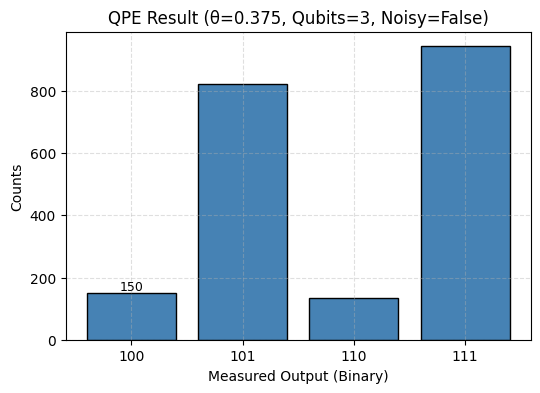

     ┌───┐                               ┌───┐                              ┌─┐»
q_0: ┤ H ├─■───────────────────────────X─┤ H ├─■─────────■──────────────────┤M├»
     ├───┤ │                   ┌───┐   │ └───┘ │P(-π/2)  │                  └╥┘»
q_1: ┤ H ├─┼─────────■─────────┤ H ├───┼───────■─────────┼─────────■─────────╫─»
     ├───┤ │         │         └───┘   │ ┌───┐           │P(-π/4)  │P(-π/2)  ║ »
q_2: ┤ H ├─┼─────────┼─────────■───────X─┤ H ├───────────■─────────■─────────╫─»
     ├───┤ │P(3π/4)  │P(3π/2)  │P(3π)    └───┘                               ║ »
q_3: ┤ X ├─■─────────■─────────■─────────────────────────────────────────────╫─»
     └───┘                                                                   ║ »
c: 3/════════════════════════════════════════════════════════════════════════╩═»
                                                                             2 »
«           
«q_0: ──────
«     ┌─┐   
«q_1: ┤M├───
«     └╥┘┌─┐
«q_2: ─╫─┤M├
«      ║ └╥┘
«q_3: ─╫──╫─
«    

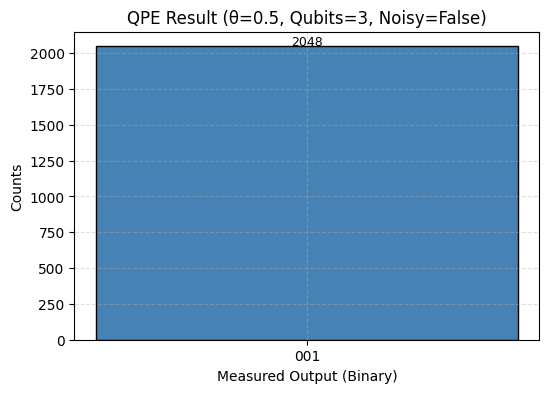

     ┌───┐                          ┌───┐                              ┌─┐   »
q_0: ┤ H ├─■──────────────────────X─┤ H ├─■─────────■──────────────────┤M├───»
     ├───┤ │              ┌───┐   │ └───┘ │P(-π/2)  │                  └╥┘┌─┐»
q_1: ┤ H ├─┼──────■───────┤ H ├───┼───────■─────────┼─────────■─────────╫─┤M├»
     ├───┤ │      │       └───┘   │ ┌───┐           │P(-π/4)  │P(-π/2)  ║ └╥┘»
q_2: ┤ H ├─┼──────┼───────■───────X─┤ H ├───────────■─────────■─────────╫──╫─»
     ├───┤ │P(π)  │P(2π)  │P(4π)    └───┘                               ║  ║ »
q_3: ┤ X ├─■──────■───────■─────────────────────────────────────────────╫──╫─»
     └───┘                                                              ║  ║ »
c: 3/═══════════════════════════════════════════════════════════════════╩══╩═»
                                                                        2  1 »
«        
«q_0: ───
«        
«q_1: ───
«     ┌─┐
«q_2: ┤M├
«     └╥┘
«q_3: ─╫─
«      ║ 
«c: 3/═╩═
«      0 

=== Comparison with 

{'001': 2048}

In [38]:
# TASK 1: Change Phase Value

print("\n=== TASK 1: Change Phase Value ===")
run_qpe(num_count_qubits=3, theta=0.25)
run_qpe(num_count_qubits=3, theta=0.375)
run_qpe(num_count_qubits=3, theta=0.5)

#When you change the phase value θ, the measured output (binary result from the counting qubits) shifts accordingly, representing the estimated phase in binary form.


=== TASK 2: Increase Counting Qubits ===
Counts collected successfully: {'00101': 141, '00111': 142, '00110': 870, '00100': 895}


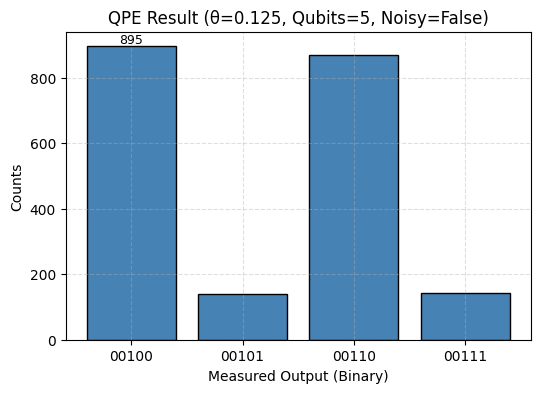

     ┌───┐                                            ┌───┐                    »
q_0: ┤ H ├─■────────────────────────────────────────X─┤ H ├─■─────────■────────»
     ├───┤ │                                        │ ├───┤ │P(-π/2)  │        »
q_1: ┤ H ├─┼────────■─────────────────────────X─────┼─┤ H ├─■─────────┼────────»
     ├───┤ │        │               ┌───┐     │     │ └───┘           │P(-π/4) »
q_2: ┤ H ├─┼────────┼────────■──────┤ H ├─────┼─────┼─────────────────■────────»
     ├───┤ │        │        │      └───┘     │     │ ┌───┐                    »
q_3: ┤ H ├─┼────────┼────────┼──────■─────────X─────┼─┤ H ├────────────────────»
     ├───┤ │        │        │      │               │ ├───┤                    »
q_4: ┤ H ├─┼────────┼────────┼──────┼───────■───────X─┤ H ├────────────────────»
     ├───┤ │P(π/4)  │P(π/2)  │P(π)  │P(2π)  │P(4π)    └───┘                    »
q_5: ┤ X ├─■────────■────────■──────■───────■──────────────────────────────────»
     └───┘                  

{'00101': 141, '00111': 142, '00110': 870, '00100': 895}

In [39]:
# TASK 2 : Increase Number of Counting Qubits

print("\n=== TASK 2: Increase Counting Qubits ===")
run_qpe(num_count_qubits=5, theta=0.125)

#When you increase the number of counting qubits, the Quantum Phase Estimation algorithm gains higher precision, meaning the measured binary output represents the phase with more bits of accuracy.



=== TASK 3: Compare With Theory ===
Counts collected successfully: {'100': 146, '110': 161, '101': 890, '111': 851}


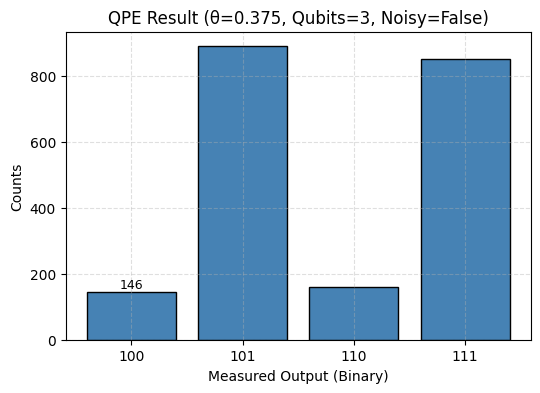

     ┌───┐                               ┌───┐                              ┌─┐»
q_0: ┤ H ├─■───────────────────────────X─┤ H ├─■─────────■──────────────────┤M├»
     ├───┤ │                   ┌───┐   │ └───┘ │P(-π/2)  │                  └╥┘»
q_1: ┤ H ├─┼─────────■─────────┤ H ├───┼───────■─────────┼─────────■─────────╫─»
     ├───┤ │         │         └───┘   │ ┌───┐           │P(-π/4)  │P(-π/2)  ║ »
q_2: ┤ H ├─┼─────────┼─────────■───────X─┤ H ├───────────■─────────■─────────╫─»
     ├───┤ │P(3π/4)  │P(3π/2)  │P(3π)    └───┘                               ║ »
q_3: ┤ X ├─■─────────■─────────■─────────────────────────────────────────────╫─»
     └───┘                                                                   ║ »
c: 3/════════════════════════════════════════════════════════════════════════╩═»
                                                                             2 »
«           
«q_0: ──────
«     ┌─┐   
«q_1: ┤M├───
«     └╥┘┌─┐
«q_2: ─╫─┤M├
«      ║ └╥┘
«q_3: ─╫──╫─
«    

{'100': 146, '110': 161, '101': 890, '111': 851}

In [40]:
# TASK 3 : Compare with Theoretical Output

print("\n=== TASK 3: Compare With Theory ===")
run_qpe(num_count_qubits=3, theta=0.375)

#The theoretical output of Quantum Phase Estimation corresponds to the binary representation of 2^𝑛 × 𝜃, where n is the number of counting qubits.
#By comparing this expected binary value with the most probable measured outcome, we can verify the correctness of the QPE algorithm



=== TASK 4: Inverse QFT Visualization ===


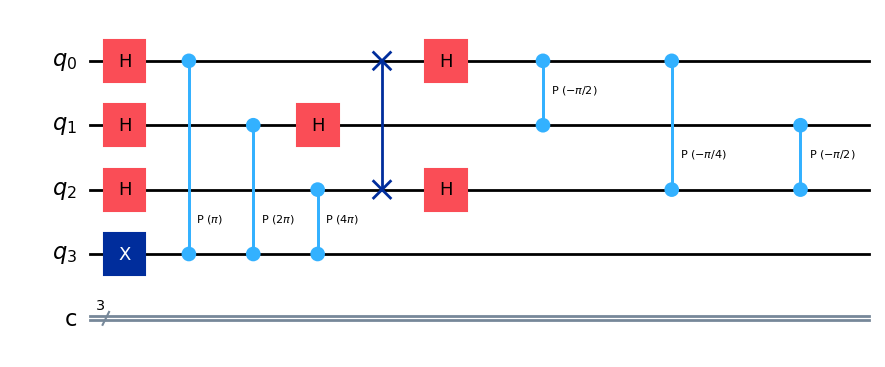

Counts collected successfully: {'001': 2048}


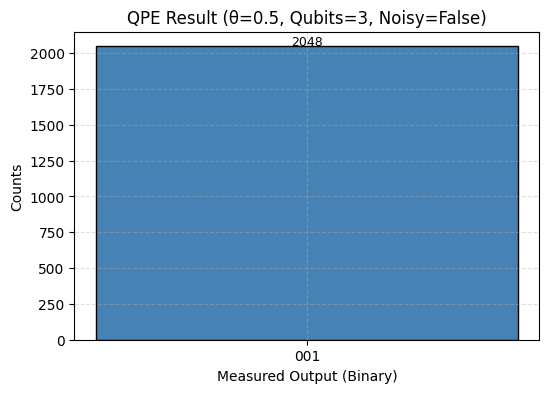

     ┌───┐                          ┌───┐                              ┌─┐   »
q_0: ┤ H ├─■──────────────────────X─┤ H ├─■─────────■──────────────────┤M├───»
     ├───┤ │              ┌───┐   │ └───┘ │P(-π/2)  │                  └╥┘┌─┐»
q_1: ┤ H ├─┼──────■───────┤ H ├───┼───────■─────────┼─────────■─────────╫─┤M├»
     ├───┤ │      │       └───┘   │ ┌───┐           │P(-π/4)  │P(-π/2)  ║ └╥┘»
q_2: ┤ H ├─┼──────┼───────■───────X─┤ H ├───────────■─────────■─────────╫──╫─»
     ├───┤ │P(π)  │P(2π)  │P(4π)    └───┘                               ║  ║ »
q_3: ┤ X ├─■──────■───────■─────────────────────────────────────────────╫──╫─»
     └───┘                                                              ║  ║ »
c: 3/═══════════════════════════════════════════════════════════════════╩══╩═»
                                                                        2  1 »
«        
«q_0: ───
«        
«q_1: ───
«     ┌─┐
«q_2: ┤M├
«     └╥┘
«q_3: ─╫─
«      ║ 
«c: 3/═╩═
«      0 

=== Comparison with 

{'001': 2048}

In [41]:
# TASK 4️ : Inverse QFT Visualization

print("\n=== TASK 4: Inverse QFT Visualization ===")
run_qpe(num_count_qubits=3, theta=0.5, visualize=True)

#The inverse QFT is the key step that transforms the phase-encoded state into a measurable binary form.
#By calling qc.draw('mpl') before the measurement step, you can visually confirm its gate structure (Hadamards and controlled-phase gates).



=== TASK 5: Noise Simulation ===
Counts collected successfully: {'010': 41, '000': 63, '001': 16, '110': 780, '101': 143, '011': 8, '111': 181, '100': 816}


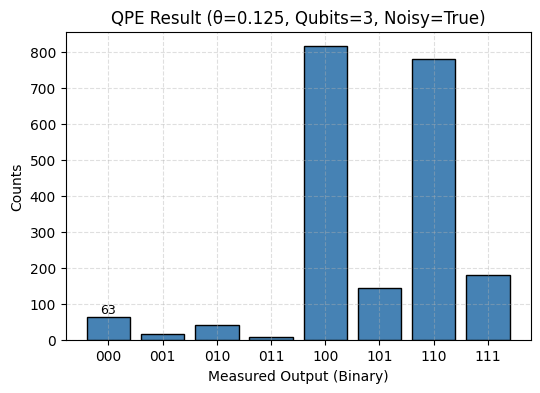

     ┌───┐                            ┌───┐                              ┌─┐   »
q_0: ┤ H ├─■────────────────────────X─┤ H ├─■─────────■──────────────────┤M├───»
     ├───┤ │                 ┌───┐  │ └───┘ │P(-π/2)  │                  └╥┘┌─┐»
q_1: ┤ H ├─┼────────■────────┤ H ├──┼───────■─────────┼─────────■─────────╫─┤M├»
     ├───┤ │        │        └───┘  │ ┌───┐           │P(-π/4)  │P(-π/2)  ║ └╥┘»
q_2: ┤ H ├─┼────────┼────────■──────X─┤ H ├───────────■─────────■─────────╫──╫─»
     ├───┤ │P(π/4)  │P(π/2)  │P(π)    └───┘                               ║  ║ »
q_3: ┤ X ├─■────────■────────■────────────────────────────────────────────╫──╫─»
     └───┘                                                                ║  ║ »
c: 3/═════════════════════════════════════════════════════════════════════╩══╩═»
                                                                          2  1 »
«        
«q_0: ───
«        
«q_1: ───
«     ┌─┐
«q_2: ┤M├
«     └╥┘
«q_3: ─╫─
«      ║ 
«c: 3/═╩═
«      0 

{'010': 41,
 '000': 63,
 '001': 16,
 '110': 780,
 '101': 143,
 '011': 8,
 '111': 181,
 '100': 816}

In [42]:
# TASK 5 : Noise Simulation

print("\n=== TASK 5: Noise Simulation ===")
run_qpe(num_count_qubits=3, theta=0.125, noisy=True)
